In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)

# Useful functions

In [13]:
def month_number_to_date_str(month_number, first_month_str='2019-08'):
    '''
    Returns a date string from `month_number` after the first month (`first_month_str`)
    Ex. 
        (month_number=0, first_month_str='2019-08') returns '2019-08-01'
        (month_number=1, first_month_str='2019-08') returns '2019-09-01'
        (month_number=38, first_month_str='2019-08') returns '2022-10-01'
    '''
    date = pd.to_datetime(first_month_str, format='%Y-%m') + pd.DateOffset(months=month_number)    
    return f'{date.year}-{date.month:02}-01'

def date_str_to_date(date_str):
    return pd.to_datetime(date_str, format='%Y-%m-%d')

def append_na_rows(g, insert_rows=8):
    gg = g.copy().reset_index(0, drop=True)
    gg = gg.reindex(index=range(insert_rows + len(gg))) 
    gg['month_number'] = gg.index.astype(int)    
    gg['first_day_of_month'] = gg['month_number'].apply(month_number_to_date_str)
    for column in ['cfips', 'county', 'state']:
        gg[column] = gg[column].unique()[0]
    gg['row_id'] = gg['cfips'] + '_' + gg['first_day_of_month']
    return gg

def plot(d, nfigs=12, ncols=6, output='test.pdf'):    
    nrows = int(np.ceil(nfigs/ncols))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*3), sharey=False, sharex=True)

    for i, cfips in enumerate(d.cfips.unique()):
        if i >= nfigs:
            break
        idx_row = int(i / ncols)
        idx_col = i % ncols
        if nrows == 1:
            ax = axs[idx_col]
        else:
            ax = axs[idx_row, idx_col]

        g = d.loc[d.cfips == cfips, :].reset_index(0, drop=True)        
        ax.plot(g['month_number'], g['y'], 'o-', label='raw')
        ax.plot(g['month_number'], g['yhat'], 'o-', label='predicted')
        cfips = g.cfips.unique()[0]
        ax.set_title(f'cfips={cfips}')
        ax.set_xlabel('month_number')
        ax.set_xlim(0, 40)
        if idx_row == 0 and idx_col == ncols-1:
            ax.legend(fancybox=False)
        if idx_col == 0:
            ax.set_ylabel('y')
    
    fig.tight_layout()
    plt.savefig(output, bbox_inches='tight')

def convert_submission(d):
    s = d.loc[d['month_number'] >= 39, :].copy()    
    s['cfips_int'] = s['cfips'].astype(int)
    s = s.sort_values(by=['month_number', 'cfips_int'])
    s['microbusiness_density'] = s['predicted_mean']
    s = s.loc[:, ['row_id', 'microbusiness_density']]
    s.to_csv('submission.csv', index=False)

# Load data

In [3]:
d = pd.read_csv('../data/train.csv') # data for 3135 cfips with 39 months each (total = 3135*39 = 122265 rows)
d['y'] = d['microbusiness_density']
d = d.drop(['active', 'microbusiness_density'], axis=1)
d['cfips'] = d['cfips'].astype(str)
d = d.groupby('cfips').apply(append_na_rows).reset_index(0, drop=True)
d['date'] = d['first_day_of_month'].apply(date_str_to_date)
d

,row_id,cfips,county,state,first_day_of_month,y,month_number,date
0,10001_2019-08-01,10001,Kent County,Delaware,2019-08-01,4.995701,0,2019-08-01
1,10001_2019-09-01,10001,Kent County,Delaware,2019-09-01,5.031902,1,2019-09-01
2,10001_2019-10-01,10001,Kent County,Delaware,2019-10-01,5.098270,2,2019-10-01
3,10001_2019-11-01,10001,Kent County,Delaware,2019-11-01,5.124666,3,2019-11-01
4,10001_2019-12-01,10001,Kent County,Delaware,2019-12-01,5.086203,4,2019-12-01
...,...,...,...,...,...,...,...,...
42,9015_2023-02-01,9015,Windham County,Connecticut,2023-02-01,NaN,42,2023-02-01
43,9015_2023-03-01,9015,Windham County,Connecticut,2023-03-01,NaN,43,2023-03-01
44,9015_2023-04-01,9015,Windham County,Connecticut,2023-04-01,NaN,44,2023-04-01
45,9015_2023-05-01,9015,Windham County,Connecticut,2023-05-01,NaN,45,2023-05-01


# Linear regression

In [4]:
def get_linear_pred(g):
    gg = g.copy().reset_index(0, drop=True)
    g = g.dropna()
    linear_model = np.poly1d(np.polyfit(g.month_number, g.y, 1))
    yhat = linear_model(gg.month_number)    
    gg['yhat'] = yhat
    return gg

In [16]:
p_lin = d.groupby('cfips', group_keys=True).apply(get_linear_pred).reset_index(0, drop=True)


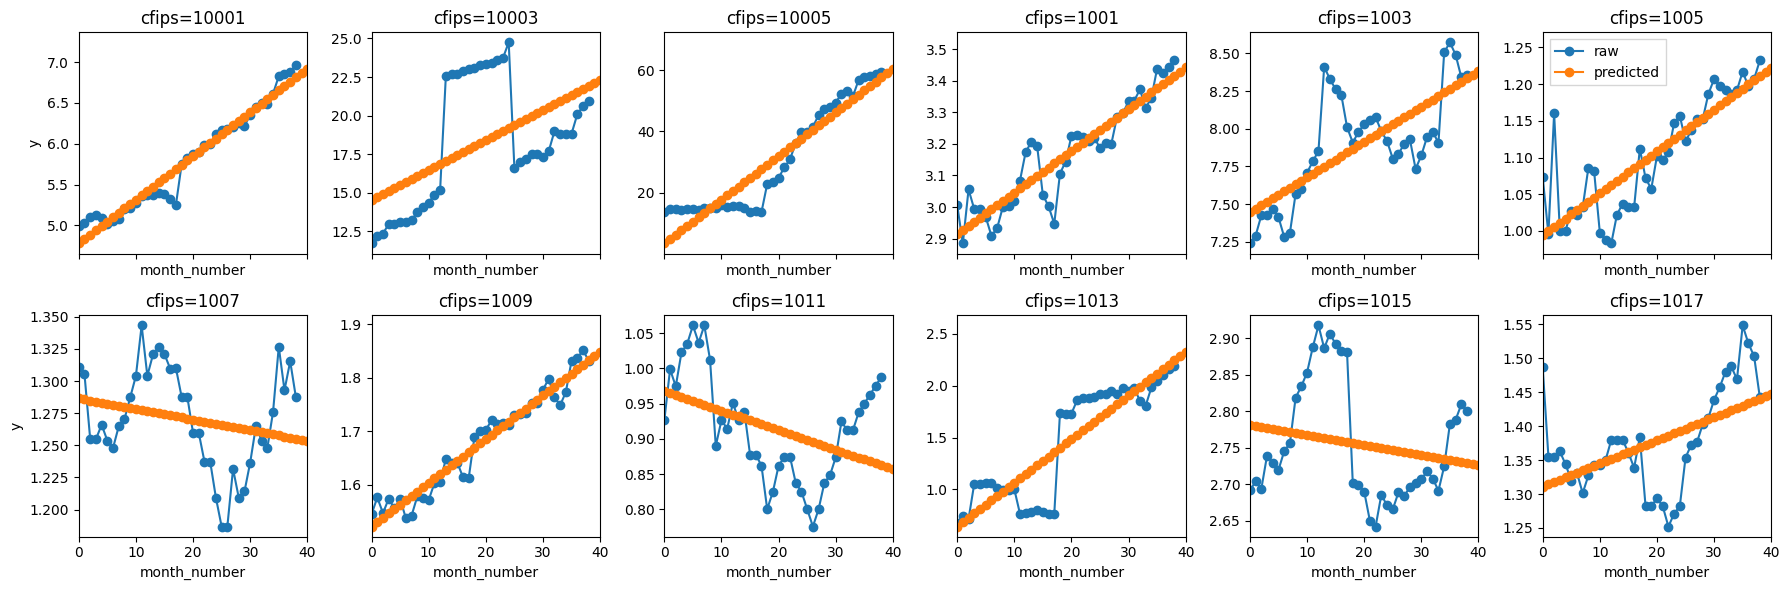

In [17]:
plot(p_lin, output='linear.pdf')

# ARIMA

In [11]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

def arimax(y, order, seasonal_order, exog=None):
    model = sm.tsa.statespace.SARIMAX(y, exog=exog, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(maxiter=300, disp=False)
    return results

def get_best_params(y, exog=None, period=0, steps=2):
    r1 = r2 = r3 = range(steps)
    pdq = list(itertools.product(r1, r2, r3))    
    if period:
        seasonal_pdq = [(x[0], x[1], x[2], period) for x in list(itertools.product(r1, r2, r3))]
    else:
        seasonal_pdq = [(0, 0, 0, 0)]
    aic_min = np.inf
    for order in pdq:
        for seasonal_order in seasonal_pdq:
            results = arimax(y, order, seasonal_order, exog=exog)
            if results.aic < aic_min:
                aic_min = results.aic
                best_params = [order, seasonal_order, results.aic]            
    return best_params

def predict(g, exog=False, target_month_number=46):
    gg = g.copy().reset_index(0, drop=True)
    y = g['y']
    if exog:
        # x = g[['edu_post_hs_ratio', 'gender_male_ratio', 'race_white_ratio', 'race_black_ratio']]
        best_params = get_best_params(y, exog=x)
    else:
        best_params = get_best_params(y)
    best_results = arimax(y, best_params[0], best_params[1])    
    pred = best_results.get_prediction(start=target_month_number - 20, end=target_month_number, dynamic=False)
    gg = gg.join(pred.predicted_mean, on=gg.month_number, how='outer')
    gg['yhat'] = gg['predicted_mean']
    gg = gg.drop(['predicted_mean'], axis=1)
    return gg

p = d.groupby('cfips', group_keys=True).apply(predict).reset_index(0, drop=True)

# def predict_all(d, ylabel, csv_name, exog=False):
#     l = []
#     for i, (uu_id, g) in enumerate(d.groupby('uu_id')):    
#         if i % 100 == 0:
#             print(f'processed {i} UUIDs')
#         predicted = predict(g, ylabel=ylabel, exog=exog)
#         l.append(predicted)        
#     df = pd.concat(l, ignore_index=True)
#     df.to_csv(csv_name, index=False)

# if not os.path.isfile('results_arima.csv'):
#     predict_all(load_featured(), 'total_claims', 'results_arima.csv')
    
# if not os.path.isfile('results_arimax.csv'):
#     predict_all(load_featured(), 'total_claims', 'results_arimax.csv', exog=True)

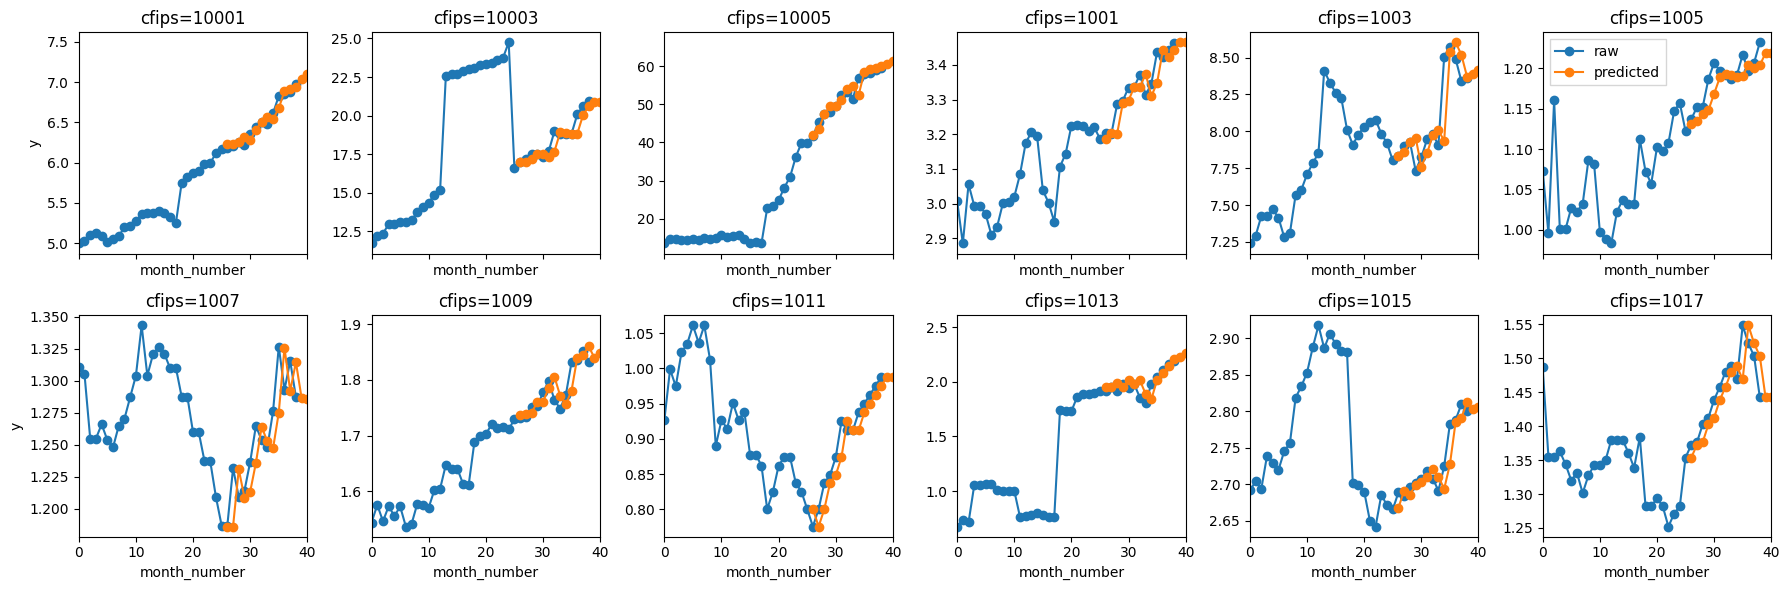

In [15]:
plot(p, output='arima.pdf')

In [ ]:
convert_submission(p)